In [1]:
"""
Hamiltonian-Simulation Benchmark Program - Qiskit
"""

import json
import os
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister

from qiskit import *

# Benchmark Name
benchmark_name = "Grover's Search"

# Noise parameters
options = { } #if Noise is None

options_noisy = { #if Noise is not None
    'plot': False,
    "thermal_factor": 0.0,
    'show_partition': False,
    "decoherence_factor": 0.9,
    "depolarization_factor": 0.9,
    "bell_depolarization_factor": 0.9,
    "decay_factor": 0.9,
    "rotation_error": {'rx':[1.0, 0.0], 'ry':[1.0, 0.0], 'rz':[1.0, 0.0]},
    "tsp_model_error": [1.0, 0.0],
}

# Selection of basis gate set for transpilation
# Note: selector 1 is a hardware agnostic gate set
basis_selector = 2
basis_gates_array = [
    [],
    ['rx', 'ry', 'rz', 'cx'],       # a common basis set, default
    ['cx', 'rz', 'sx', 'x'],        # IBM default basis set
    ['rx', 'ry', 'rxx'],            # IonQ default basis set
    ['h', 'p', 'cx'],               # another common basis set
    ['u', 'cx']                     # general unitaries basis gates
]

np.random.seed(0)

# saved circuits and subcircuits for display
QC_ = None
XX_ = None
YY_ = None
ZZ_ = None
XXYYZZ_ = None

# for validating the implementation of XXYYZZ operation
_use_XX_YY_ZZ_gates = False

# import precalculated data to compare against
filename = os.path.join("precalculated_data.json")
with open(filename, 'r') as file:
    data = file.read()
precalculated_data = json.loads(data)

In [2]:
############### Circuit Definition

def HamiltonianSimulation(n_spins, K, t, w, h_x, h_z):
    '''
    Construct a Qiskit circuit for Hamiltonian Simulation
    :param n_spins:The number of spins to simulate
    :param K: The Trotterization order
    :param t: duration of simulation
    :return: return a Qiskit circuit for this Hamiltonian
    '''
    
    num_qubits = n_spins
    secret_int = f"{K}-{t}"
    
    # allocate qubits
    qr = QuantumRegister(n_spins); cr = ClassicalRegister(n_spins)
    qc = QuantumCircuit(qr, cr, name=f"hamsim-{num_qubits}-{secret_int}")
    tau = t / K

    # start with initial state of 1010101...
    for k in range(0, n_spins, 2):
        qc.x(qr[k])
    qc.barrier()

    # loop over each trotter step, adding gates to the circuit defining the hamiltonian
    for k in range(K):
    
        # the Pauli spin vector product
        [qc.rx(2 * tau * w * h_x[i], qr[i]) for i in range(n_spins)]
        [qc.rz(2 * tau * w * h_z[i], qr[i]) for i in range(n_spins)]
        qc.barrier()
        
        # Basic implementation of exp(i * t * (XX + YY + ZZ))
        if _use_XX_YY_ZZ_gates:

            # XX operator on each pair of qubits in linear chain
            for j in range(2):
                for i in range(j%2, n_spins - 1, 2):
                    qc.append(xx_gate(tau).to_instruction(), [qr[i], qr[(i + 1) % n_spins]])

            # YY operator on each pair of qubits in linear chain
            for j in range(2):
                for i in range(j%2, n_spins - 1, 2):
                    qc.append(yy_gate(tau).to_instruction(), [qr[i], qr[(i + 1) % n_spins]])

            # ZZ operation on each pair of qubits in linear chain
            for j in range(2):
                for i in range(j%2, n_spins - 1, 2):
                    qc.append(zz_gate(tau).to_instruction(), [qr[i], qr[(i + 1) % n_spins]])

        # Use an optimal XXYYZZ combined operator
        # See equation 1 and Figure 6 in https://arxiv.org/pdf/quant-ph/0308006.pdf
        else:

            # optimized XX + YY + ZZ operator on each pair of qubits in linear chain
            for j in range(2):
                for i in range(j % 2, n_spins - 1, 2):
                    qc.append(xxyyzz_opt_gate(tau).to_instruction(), [qr[i], qr[(i + 1) % n_spins]])

        qc.barrier()

    # measure all the qubits used in the circuit
    for i_qubit in range(n_spins):
        qc.measure(qr[i_qubit], cr[i_qubit])

    # save smaller circuit example for display
    global QC_    
    if QC_ == None or n_spins <= 6:
        if n_spins < 9: QC_ = qc

    return qc

############### XX, YY, ZZ Gate Implementations

# Simple XX gate on q0 and q1 with angle 'tau'
def xx_gate(tau):
    qr = QuantumRegister(2); qc = QuantumCircuit(qr, name="xx_gate")
    qc.h(qr[0])
    qc.h(qr[1])
    qc.cx(qr[0], qr[1])
    qc.rz(3.1416*tau, qr[1])
    qc.cx(qr[0], qr[1])
    qc.h(qr[0])
    qc.h(qr[1])
    
    # save circuit example for display
    global XX_    
    XX_ = qc
    
    return qc

# Simple YY gate on q0 and q1 with angle 'tau'    
def yy_gate(tau):
    qr = QuantumRegister(2); qc = QuantumCircuit(qr, name="yy_gate")
    qc.s(qr[0])
    qc.s(qr[1])
    qc.h(qr[0])
    qc.h(qr[1])
    qc.cx(qr[0], qr[1])
    qc.rz(3.1416*tau, qr[1])
    qc.cx(qr[0], qr[1])
    qc.h(qr[0])
    qc.h(qr[1])
    qc.sdg(qr[0])
    qc.sdg(qr[1])

    # save circuit example for display
    global YY_    
    YY_ = qc

    return qc

# Simple ZZ gate on q0 and q1 with angle 'tau'
def zz_gate(tau):
    qr = QuantumRegister(2); qc = QuantumCircuit(qr, name="zz_gate")
    qc.cx(qr[0], qr[1])
    qc.rz(3.1416*tau, qr[1])
    qc.cx(qr[0], qr[1])

    # save circuit example for display
    global ZZ_    
    ZZ_ = qc

    return qc

# Optimal combined XXYYZZ gate (with double coupling) on q0 and q1 with angle 'tau'
def xxyyzz_opt_gate(tau):
    alpha = tau; beta = tau; gamma = tau
    qr = QuantumRegister(2); qc = QuantumCircuit(qr, name="xxyyzz_opt")
    qc.rz(3.1416/2, qr[1])
    qc.cx(qr[1], qr[0])
    qc.rz(3.1416*gamma - 3.1416/2, qr[0])
    qc.ry(3.1416/2 - 3.1416*alpha, qr[1])
    qc.cx(qr[0], qr[1])
    qc.ry(3.1416*beta - 3.1416/2, qr[1])
    qc.cx(qr[1], qr[0])
    qc.rz(-3.1416/2, qr[0])

    # save circuit example for display
    global XXYYZZ_    
    XXYYZZ_ = qc

    return qc
############################################
# DATA ANALYSIS - FIDELITY CALCULATIONS

## Uniform distribution function commonly used
def rescale_fidelity(fidelity, floor_fidelity, new_floor_fidelity):
    """
    Linearly rescales our fidelities to allow comparisons of fidelities across benchmarks
    
    fidelity: raw fidelity to rescale
    floor_fidelity: threshold fidelity which is equivalent to random guessing
    new_floor_fidelity: what we rescale the floor_fidelity to 

    Ex, with floor_fidelity = 0.25, new_floor_fidelity = 0.0:
        1 -> 1;
        0.25 -> 0;
        0.5 -> 0.3333;
    """
    rescaled_fidelity = (1-new_floor_fidelity)/(1-floor_fidelity) * (fidelity - 1) + 1
    
    # ensure fidelity is within bounds (0, 1)
    if rescaled_fidelity < 0:
        rescaled_fidelity = 0.0
    if rescaled_fidelity > 1:
        rescaled_fidelity = 1.0
    
    return rescaled_fidelity
    
def uniform_dist(num_state_qubits):
    dist = {}
    for i in range(2**num_state_qubits):
        key = bin(i)[2:].zfill(num_state_qubits)
        dist[key] = 1/(2**num_state_qubits)
    return dist                

### Analysis methods to be expanded and eventually compiled into a separate analysis.py file
import math, functools

def hellinger_fidelity_with_expected(p, q):
    """ p: result distribution, may be passed as a counts distribution
        q: the expected distribution to be compared against

    References:
        `Hellinger Distance @ wikipedia <https://en.wikipedia.org/wiki/Hellinger_distance>`_
        Qiskit Hellinger Fidelity Function
    """
    p_sum = sum(p.values())
    q_sum = sum(q.values())

    if q_sum == 0:
        print("ERROR: polarization_fidelity(), expected distribution is invalid, all counts equal to 0")
        return 0

    p_normed = {}
    for key, val in p.items():
        if p_sum != 0:
            p_normed[key] = val/p_sum
        else:
            p_normed[key] = 0

    q_normed = {}
    for key, val in q.items():
        q_normed[key] = val/q_sum

    total = 0
    for key, val in p_normed.items():
        if key in q_normed.keys():
            total += (np.sqrt(val) - np.sqrt(q_normed[key]))**2
            del q_normed[key]
        else:
            total += val
    total += sum(q_normed.values())
    
    # in some situations (error mitigation) this can go negative, use abs value
    if total < 0:
        print(f"WARNING: using absolute value in fidelity calculation")
        total = abs(total)
        
    dist = np.sqrt(total)/np.sqrt(2)
    fidelity = (1-dist**2)**2

    return fidelity

def polarization_fidelity(counts, correct_dist, thermal_dist=None):
    """
    Combines Hellinger fidelity and polarization rescaling into fidelity calculation
    used in every benchmark

    counts: the measurement outcomes after `num_shots` algorithm runs
    correct_dist: the distribution we expect to get for the algorithm running perfectly
    thermal_dist: optional distribution to pass in distribution from a uniform
                  superposition over all states. If `None`: generated as 
                  `uniform_dist` with the same qubits as in `counts`
                  
    returns both polarization fidelity and the hellinger fidelity

    Polarization from: `https://arxiv.org/abs/2008.11294v1`
    """
    num_measured_qubits = len(list(correct_dist.keys())[0])
    print(num_measured_qubits)
    
    counts = {k.zfill(num_measured_qubits): v for k, v in counts.items()}
    
    # calculate hellinger fidelity between measured expectation values and correct distribution
    hf_fidelity = hellinger_fidelity_with_expected(counts,correct_dist)
    
    # to limit cpu and memory utilization, skip noise correction if more than 16 measured qubits
    if num_measured_qubits > 16:
        return { 'fidelity':hf_fidelity, 'hf_fidelity':hf_fidelity }

    # if not provided, generate thermal dist based on number of qubits
    if thermal_dist == None:
        thermal_dist = uniform_dist(num_measured_qubits)

    # set our fidelity rescaling value as the hellinger fidelity for a depolarized state
    floor_fidelity = hellinger_fidelity_with_expected(thermal_dist, correct_dist)

    # rescale fidelity result so uniform superposition (random guessing) returns fidelity
    # rescaled to 0 to provide a better measure of success of the algorithm (polarization)
    new_floor_fidelity = 0
    fidelity = rescale_fidelity(hf_fidelity, floor_fidelity, new_floor_fidelity)

    return { 'fidelity':fidelity, 'hf_fidelity':hf_fidelity }

In [3]:
# Function to calculate circuit depth
def calculate_circuit_depth(qc):
    # Calculate the depth of the circuit
    depth = qc.depth()
    return depth

def combine_probabilities(prob, num_qubits):
    proj_prob = {}
    input_size = num_qubits-1
    # Generate binary combinations for n qubits
    binary_combinations = [bin(i)[2:].zfill(input_size) for i in range(2**input_size)]

    # Combine probabilities and errors for each projection
    if input_size<2:
        for i in range(2**(input_size-1)):
            proj_prob[bin(i)[2:].zfill(input_size-1)] = prob.get(bin(i)[2:].zfill(input_size-1) + '0', 0) + prob.get(bin(i)[2:].zfill(input_size-1) + '1', 0)
    else:
        for i in range(2**(input_size-1)):
            proj_prob[bin(i)[2:].zfill(input_size-1) + '0'] = sum(prob[bin(i)[2:].zfill(input_size-1) + '0' + str(j)] for j in range(2))
            proj_prob[bin(i)[2:].zfill(input_size-1) + '1'] = sum(prob[bin(i)[2:].zfill(input_size-1) + '1' + str(j)] for j in range(2))

    return proj_prob

def calculate_transpiled_depth(qc,basis_selector):
    # use either the backend or one of the basis gate sets
    if basis_selector == 0:
        qc = transpile(qc, backend)
        
    else:
        basis_gates = basis_gates_array[basis_selector]
        qc = transpile(qc, basis_gates=basis_gates, seed_transpiler=0)
    transpiled_depth = qc.depth()
    return transpiled_depth

def plot_data(fidelity_data, Hf_fidelity_data, title):
    avg_fidelity_means = []
    avg_Hf_fidelity_means = []
    avg_num_qubits_values = list(fidelity_data.keys())

    # Calculate the average fidelity and Hamming fidelity for each unique number of qubits
    for num_qubits in avg_num_qubits_values:
        avg_fidelity = np.average(fidelity_data[num_qubits])
        avg_fidelity_means.append(avg_fidelity)

        avg_Hf_fidelity = np.mean(Hf_fidelity_data[num_qubits])
        avg_Hf_fidelity_means.append(avg_Hf_fidelity)
    
    

    # Plot the data
    x = np.arange(len(avg_num_qubits_values))
    
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    rects2 =ax.bar(x, avg_Hf_fidelity_means, width=0.4, label='Hellinger Fidelity',color="magenta")
    rects1 = ax.bar(x, avg_fidelity_means, width=0.2, label='Normalized Fidelity', color="blue")
    
    ax.set_xlabel('Number of Qubits')
    ax.set_ylabel('Average Value')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(avg_num_qubits_values)
    ax.legend()
    
    # Add labels to the bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:.5f}'.format(height),  # Formatting to two decimal places
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    
    plt.show()
    print(fidelity_data)
    print(Hf_fidelity_data)
    print(avg_fidelity_means)
    print(avg_Hf_fidelity_means)
    
backend = BasicAer.get_backend('dm_simulator')

Grover's Search Benchmark Program - Qiskit
************
Executing [3] circuits with num_qubits = 2
qc of 2 qubits of type <class 'type'>
            ░ ┌───────────────┐┌───────────────┐ ░ ┌─────────────┐ ░ »
q0_0: ──────░─┤ Rx(0.0025855) ├┤ Rz(-0.057871) ├─░─┤1            ├─░─»
      ┌───┐ ░ ├───────────────┤└┬──────────────┤ ░ │  xxyyzz_opt │ ░ »
q0_1: ┤ X ├─░─┤ Rx(-0.025609) ├─┤ Rz(0.009192) ├─░─┤0            ├─░─»
      └───┘ ░ └───────────────┘ └──────────────┘ ░ └─────────────┘ ░ »
c0: 2/═══════════════════════════════════════════════════════════════»
                                                                     »
«      ┌───────────────┐┌───────────────┐ ░ ┌─────────────┐ ░ ┌───────────────┐»
«q0_0: ┤ Rx(0.0025855) ├┤ Rz(-0.057871) ├─░─┤1            ├─░─┤ Rx(0.0025855) ├»
«      ├───────────────┤└┬──────────────┤ ░ │  xxyyzz_opt │ ░ ├───────────────┤»
«q0_1: ┤ Rx(-0.025609) ├─┤ Rz(0.009192) ├─░─┤0            ├─░─┤ Rx(-0.025609) ├»
«      └───────────────┘ └──────────────┘ 

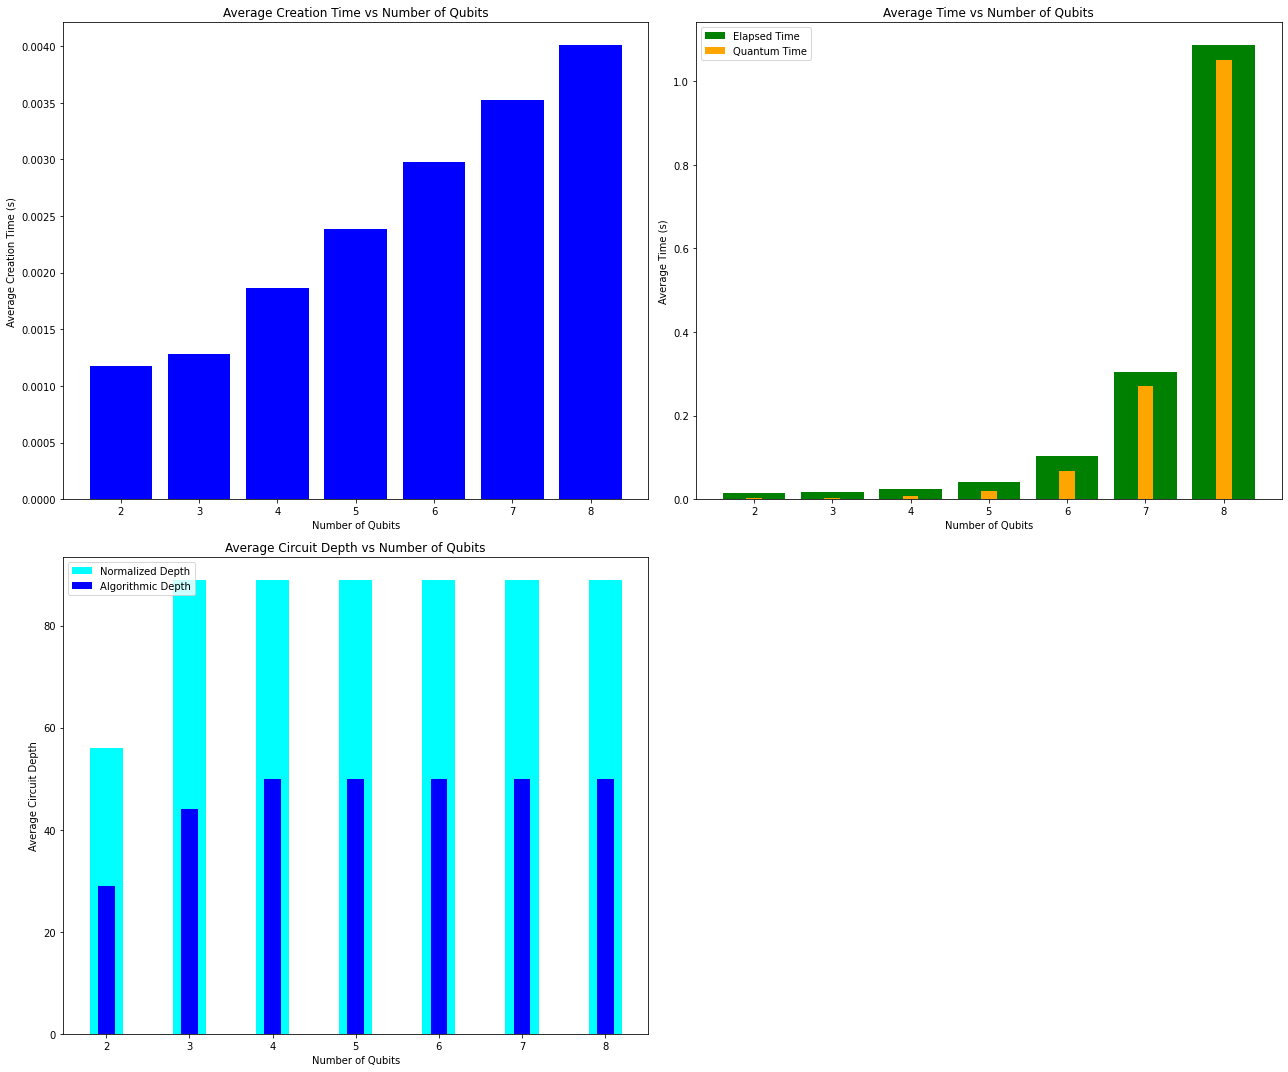

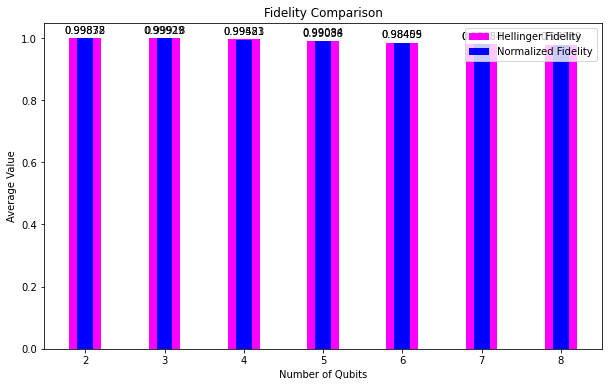

{2: [0.9983223426234131, 0.9983223426234131, 0.9983223426234131], 3: [0.9991750215069183, 0.9991750215069183, 0.9991750215069183], 4: [0.9948080346952896, 0.9948080346952896, 0.9948080346952896], 5: [0.9903834185670748, 0.9903834185670748, 0.9903834185670748], 6: [0.9840945580451746, 0.9840945580451746, 0.9840945580451746], 7: [0.9795428457226019, 0.9795428457226019, 0.9795428457226019], 8: [0.9777982000708947, 0.9777982000708947, 0.9777982000708947]}
{2: [0.99878, 0.99878, 0.99878], 3: [0.9992899999999999, 0.9992899999999999, 0.9992899999999999], 4: [0.9952300000000001, 0.9952300000000001, 0.9952300000000001], 5: [0.9908399999999999, 0.9908399999999999, 0.9908399999999999], 6: [0.9845499999999999, 0.9845499999999999, 0.9845499999999999], 7: [0.9798699999999999, 0.9798699999999999, 0.9798699999999999], 8: [0.9779899999999999, 0.9779899999999999, 0.9779899999999999]}
[0.9983223426234131, 0.9991750215069183, 0.9948080346952896, 0.9903834185670748, 0.9840945580451746, 0.979542845722602, 0

In [4]:
################ Benchmark Loop

# Execute program with default parameters
def run(min_qubits=2, max_qubits=8, max_circuits=3, skip_qubits=1, num_shots=100,use_XX_YY_ZZ_gates = False):
    print(f"{benchmark_name} Benchmark Program - Qiskit")

    global max_ckts
    max_ckts = max_circuits
    
    creation_times = []
    elapsed_times = []
    quantum_times = []
    circuit_depths = []
    transpiled_depths = []
    fidelity_data = {}
    Hf_fidelity_data = {}

    global min_qbits,max_qbits,skp_qubits

    min_qbits = min_qubits
    max_qbits = max_qubits
    skp_qubits = skip_qubits
    
    # validate parameters (smallest circuit is 2 qubits)
    max_qubits = max(2, max_qubits)
    min_qubits = min(max(2, min_qubits), max_qubits)
    if min_qubits % 2 == 1: min_qubits += 1   # min_qubits must be even
    skip_qubits = max(1, skip_qubits)
    #print(f"min, max qubits = {min_qubits} {max_qubits}")

    # set the flag to use an XX YY ZZ shim if given
    global _use_XX_YY_ZZ_gates
    _use_XX_YY_ZZ_gates = use_XX_YY_ZZ_gates
    if _use_XX_YY_ZZ_gates:
        print("... using unoptimized XX YY ZZ gates")

     ##########
    
    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for num_qubits in range(min_qubits, max_qubits + 1, skip_qubits):

        # reset random seed
        np.random.seed(0)

        # determine number of circuits to execute for this group
        num_circuits = max(1, max_circuits)

        fidelity_data[num_qubits] = []
        Hf_fidelity_data[num_qubits] = []
        
        print(f"************\nExecuting [{num_circuits}] circuits with num_qubits = {num_qubits}")

        # parameters of simulation
        #### CANNOT BE MODIFIED W/O ALSO MODIFYING PRECALCULATED DATA #########
        w = precalculated_data['w']  # strength of disorder
        k = precalculated_data['k']  # Trotter error.
               # A large Trotter order approximates the Hamiltonian evolution better.
               # But a large Trotter order also means the circuit is deeper.
               # For ideal or noise-less quantum circuits, k >> 1 gives perfect hamiltonian simulation.
        t = precalculated_data['t']  # time of simulation
        #######################################################################

        # loop over only 1 circuit
        for circuit_id in range(num_circuits):
        
            #print(circuit_id)
        
            # create the circuit for given qubit size and simulation parameters, store time metric
            ts = time.time()
            h_x = precalculated_data['h_x'][:num_qubits] # precalculated random numbers between [-1, 1]
            h_z = precalculated_data['h_z'][:num_qubits]
            qc = HamiltonianSimulation(num_qubits, K=k, t=t, w=w, h_x= h_x, h_z=h_z).reverse_bits()
            #creation time
            creation_time = time.time() - ts
            creation_times.append(creation_time)
            print(f"qc of {num_qubits} qubits of type {type}")
            print(qc)
            
            # collapse the sub-circuits used in this benchmark (for qiskit)
            qc = qc.decompose()

            # Calculate circuit depth
            depth = calculate_circuit_depth(qc)
            circuit_depths.append(depth)

            # Calculate transpiled circuit depth
            transpiled_depth = calculate_transpiled_depth(qc,basis_selector)
            transpiled_depths.append(transpiled_depth)
            
            #execution
            ts = time.time()
            job = execute(qc, backend, shots=num_shots, **options)
            result = job.result()
            elapsed_time = time.time() - ts
            elapsed_times.append(elapsed_time)

            # Calculate quantum processing time (excluding creation time)
            quantum_time = result.results[0].running_time_taken
            quantum_times.append(quantum_time)

            #ensemble probability
            prob = result.results[0].data.partial_probability
            print("prob",prob)
            counts = prob

            for key in counts.keys():
               counts[key] = int(counts[key] * num_shots)
            print("counts=",counts)

            correct_dist = precalculated_data[f"Qubits - {num_qubits}"]
            print("correct_dist =",correct_dist)

            # use polarization fidelity with rescaling
            fidelity_dict = polarization_fidelity(counts, correct_dist)
            print("fidelity_dict=",fidelity_dict)

            fidelity_data[num_qubits].append(fidelity_dict['fidelity'])
            Hf_fidelity_data[num_qubits].append(fidelity_dict['hf_fidelity'])

    ##########
    
    # print a sample circuit
    print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
   
    if _use_XX_YY_ZZ_gates:
        print("\nXX, YY, ZZ =")
        print(XX_); print(YY_); print(ZZ_)
    else:
        print("\nXXYYZZ_opt =")
        print(XXYYZZ_)

    return creation_times, elapsed_times, quantum_times, circuit_depths, transpiled_depths, fidelity_data, Hf_fidelity_data

# Execute the benchmark program, accumulate metrics, and calculate circuit depths
creation_times, elapsed_times, quantum_times, circuit_depths,transpiled_depths, fidelity_data, Hf_fidelity_data = run()

# Define the range of qubits for the x-axis
num_qubits_range = range(min_qbits, max_qbits+1,skp_qubits)
print("num_qubits_range =",num_qubits_range)

# Calculate average creation time, elapsed time, quantum processing time, and circuit depth for each number of qubits
avg_creation_times = [np.mean(creation_times[i:i+max_ckts]) for i in range(0, len(creation_times), max_ckts)]
avg_elapsed_times = [np.mean(elapsed_times[i:i+max_ckts]) for i in range(0, len(elapsed_times), max_ckts)]
avg_quantum_times = [np.mean(quantum_times[i:i+max_ckts]) for i in range(0, len(quantum_times), max_ckts)]
avg_circuit_depths = [np.mean(circuit_depths[i:i+max_ckts]) for i in range(0, len(circuit_depths), max_ckts)]
avg_transpiled_depths = [np.mean(transpiled_depths[i:i+max_ckts]) for i in range(0, len(transpiled_depths), max_ckts)]

print(f"avg_creation_times={avg_creation_times}")
# Plot histograms for average creation time, average elapsed time, average quantum processing time, and average circuit depth versus the number of qubits
plt.figure(figsize=(18, 15))

plt.subplot(2, 2, 1)
plt.xticks(range(min(num_qubits_range), max(num_qubits_range)+1, skp_qubits))
plt.bar(num_qubits_range, avg_creation_times, color='blue')
plt.xlabel('Number of Qubits')
plt.ylabel('Average Creation Time (s)')
plt.title('Average Creation Time vs Number of Qubits')

plt.subplot(2, 2, 2)
plt.xticks(range(min(num_qubits_range), max(num_qubits_range)+1, skp_qubits))
plt.bar(num_qubits_range, avg_elapsed_times, color='green',label ='Elapsed Time')
plt.bar(num_qubits_range, avg_quantum_times, color='orange',label ='Quantum Time', width=0.2)
plt.xlabel('Number of Qubits')
plt.ylabel('Average Time (s)')
plt.title('Average Time vs Number of Qubits')
plt.legend()

plt.subplot(2, 2, 3)
plt.xticks(range(min(num_qubits_range), max(num_qubits_range)+1, skp_qubits))
plt.bar(num_qubits_range, avg_transpiled_depths, color='cyan', label='Normalized Depth', width=0.4)  # Adjust width here
plt.bar(num_qubits_range, avg_circuit_depths, color='blue', label='Algorithmic Depth', width=0.2)  # Adjust width here
plt.xlabel('Number of Qubits')
plt.ylabel('Average Circuit Depth')
plt.title('Average Circuit Depth vs Number of Qubits')
plt.legend()


plt.tight_layout()
plt.show()

# Calculate the fidelity data
plot_data(fidelity_data, Hf_fidelity_data, "Fidelity Comparison")